In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix, average_precision_score
import joblib
import warnings
warnings.filterwarnings("ignore")

### Reading the dataset

In [35]:
df = pd.read_csv('../assets/preprocessed_fraud_dataset.csv')

### Separate features and target

In [36]:
X = df.drop('Fraud_Label', axis=1)
y = df['Fraud_Label']

### Define categorical and numerical features

In [37]:
categorical_features = ['Transaction_Type', 'Device_Type', 'Location', 
                       'Merchant_Category', 'Authentication_Method']
numerical_features = [col for col in X.columns if col not in categorical_features]

### Create preprocessing pipeline

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

### Split data

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Model Selection and Training

#### Define models to try

In [40]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
}

In [41]:
print("Columns in dataframe:", df.columns.tolist())

Columns in dataframe: ['Transaction_Amount', 'Transaction_Type', 'Account_Balance', 'Device_Type', 'Location', 'Merchant_Category', 'IP_Address_Flag', 'Previous_Fraudulent_Activity', 'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Transaction_Distance', 'Authentication_Method', 'Risk_Score', 'Is_Weekend', 'Fraud_Label', 'Hour', 'DayOfWeek', 'Is_Night', 'Amount_to_Balance_Ratio', 'Amount_Deviation', 'High_Risk_Category']


#### Train and evaluate models

In [42]:
results = {}
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Store results
    results[name] = {
        'classification_report': classification_report(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }
    
    print(f"{name} Results:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}\n")

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      6787
           1       0.63      0.80      0.71      3213

    accuracy                           0.79     10000
   macro avg       0.76      0.79      0.77     10000
weighted avg       0.81      0.79      0.79     10000

ROC-AUC: 0.8901

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6787
           1       1.00      1.00      1.00      3213

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC: 1.0000

Gradient Boosting Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6787
           1       1.00      1.00      1.00      3213

    accuracy                           1.00     10000
   macro avg   

### Hyperparameter Tuning (Example with XGBoost)

#### Create pipeline with XGBoost

In [43]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])))])

#### Define parameter grid

In [44]:
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

#### Perform grid search

In [45]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Transaction_Amount',
                                                                          'Account_Balance',
                                                                          'IP_Address_Flag',
                                                                          'Previous_Fraudulent_Activity',
                                                                          'Daily_Transaction_Count',
                                                                          'Avg_Transaction_Amount_7d',
                                                                          'Failed_Transaction_Count_7d',
                                                                          'Transaction_Distance',
                                                                          'Risk_Score',
                                                                          'Is_Weekend',
                                                                          'Hour',
                                                                          'DayO...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='roc_auc')

#### Best model

In [46]:
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best ROC-AUC: {grid_search.best_score_:.4f}")

Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__subsample': 0.8}
Best ROC-AUC: 1.0000


#### Get feature names after one-hot encoding

In [47]:
preprocessor.fit(X)
feature_names = (numerical_features + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

#### Get feature importances from best model

In [48]:
importances = best_model.named_steps['classifier'].feature_importances_

#### Create DataFrame for visualization

In [49]:
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

#### Plot top 20 features

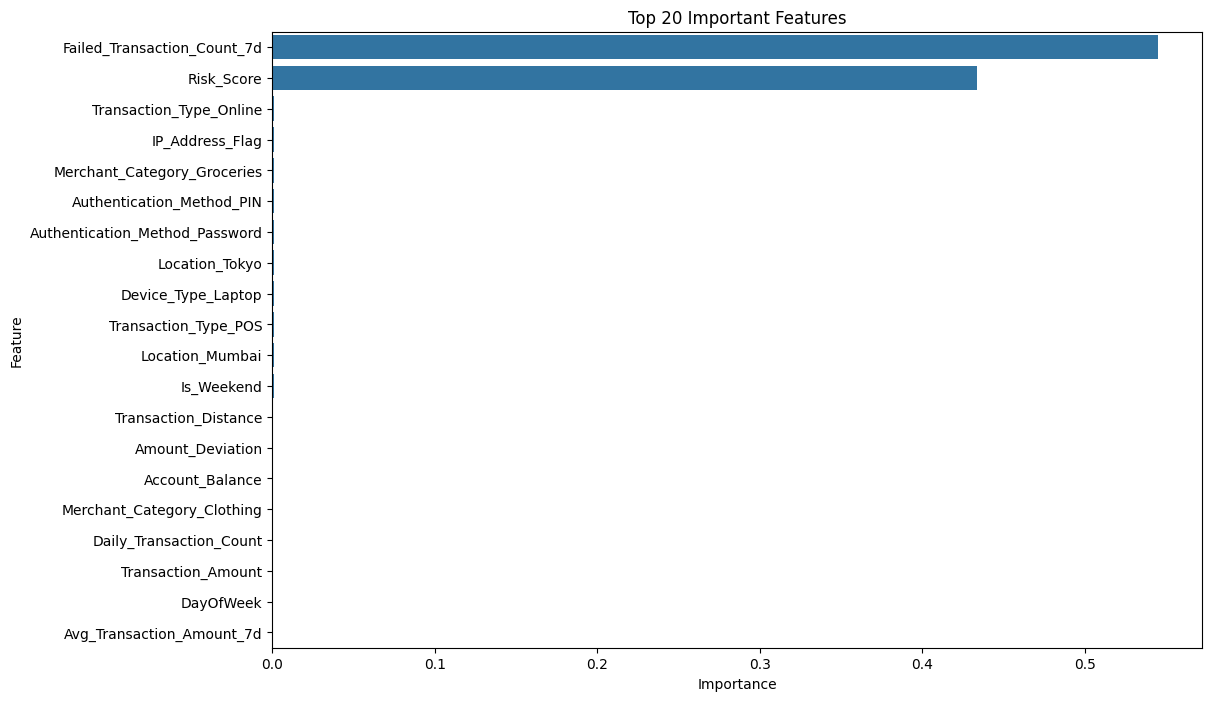

In [50]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Important Features')
plt.show()

### Final Model Deployment

#### Save the model

In [59]:
joblib.dump({
    'model': best_model,
    'feature_names': np.array(feature_names).tolist(),  # Ensures conversion to list
    'categorical_features': categorical_features,
    'training_columns': X_train.columns.tolist()  # Also save original column order
}, '../assets/fraud_detection_model_with_metadata.pkl')

['../assets/fraud_detection_model_with_metadata.pkl']